In [12]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

from lambeq import BobcatParser, Rewriter, IQPAnsatz
from torchvision import models, transforms
from PIL import Image
import requests
import numpy as np
import io
import pandas as pd
import tensorflow as tf

from lambeq.backend.grammar import Box, Id, Ty, Diagram, Layer


def download_image(url):
    response = requests.get(url)
    img = Image.open(io.BytesIO(response.content))
    return img

def preprocess_image(img, target_size=(32, 32)):
    print("==============================================================")
    # Show original image
    # print("Displayed Original Image.")
    # img.show()

    # Convert to grayscale if specified and the image is not already grayscale
    if img.mode != 'L':
        img = img.convert('L')
        print(f" Original image is RGB | new image mode = {img.mode}\n")
    else: 
        print(f" Original image is Greyscale | image mode = {img.mode}\n")
    
    # Resize the image
    print(f" Before Image size: {img.size}")
    img = img.resize(target_size)
    print(f" After Image size: {img.size}\n")
    
    # Convert the image to a numpy array
    img_array = np.array(img)
    print(f" Shape after converting to numpy array: {img_array.shape}")
    
    # Normalize the image
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    print(f" Shape after adding batch dimension: {img_array.shape}")
    img_array = np.expand_dims(img_array, axis=-1)
    print(f" Shape after adding channel dimension: {img_array.shape}")
    print("==============================================================\n")

    return img_array


# ===================================================
# Read the CSV file
# ===================================================

file_path = os.path.join(os.getcwd(), "database.csv")
df = pd.read_csv(file_path)

# Extract the sentence
sentence = df['sentence'].iloc[0]
image_pos = df['pos_url'].iloc[0]
image_neg = df['neg_url'].iloc[0]

# Print the first row
print(f"Sentence: {sentence} ")
print(f"Image Pos: {image_pos}")
print(f"Image Neg: {image_neg}")

# ===================================================
#  Pre-process images
# ===================================================

import numpy as np
import matplotlib.pyplot as plt

image_urls = [image_pos, image_neg]
print(f"Image URLS: {image_urls}\n")

# Download and preprocess images
images = []
for image_url in image_urls:
    img = download_image(image_url)
    print(f"Image details: {img}")
    img_array = preprocess_image(img, target_size=(32, 32))
    images.append(img_array)

# Stack images into a single array for model input
images_array = np.vstack(images)


Sentence: man stand behind the wall 
Image Pos: https://previews.123rf.com/images/ryanking999/ryanking9991702/ryanking999170200409/72735211-apuesto-hombre-de-pie-con-pared-de-ladrillo-asi%C3%A1tico.jpg
Image Neg: https://previews.123rf.com/images/ryanking999/ryanking9991703/ryanking999170300165/72844322-hombre-sentarse-y-sentirse-deprimido-con-pared-de-ladrillo-asi%C3%A1tico.jpg
Image URLS: ['https://previews.123rf.com/images/ryanking999/ryanking9991702/ryanking999170200409/72735211-apuesto-hombre-de-pie-con-pared-de-ladrillo-asi%C3%A1tico.jpg', 'https://previews.123rf.com/images/ryanking999/ryanking9991703/ryanking999170300165/72844322-hombre-sentarse-y-sentirse-deprimido-con-pared-de-ladrillo-asi%C3%A1tico.jpg']



AttributeError: 'Ty' object has no attribute 'open'

In [13]:
# Create a subclass for the Box class to include additional dataset details
class ImageBox(Box):
    def __init__(self, name, dom, cod, image=None, label=None):
        super().__init__(name, dom, cod)
        self.image = image
        self.label = label

## Diagram 
temp_image = images_array[0]

# Define a custom type for images
image_type = Ty('Image')

# Define morphisms
# image_Box = Box('Image Processing', dom=image_type, cod=image_type)
image_diagram = ImageBox('Image Positive', image_type, image_type, image=images_array[0], label = 0)

print("Diagram details :")
print(f" label = {image_diagram.label}")
print(f" image = {image_diagram.image}")


Diagram details :
 label = 0
 image = [[[0.80392157]
  [0.81960784]
  [0.78823529]
  ...
  [0.47843137]
  [0.45882353]
  [0.43137255]]

 [[0.81960784]
  [0.81176471]
  [0.81176471]
  ...
  [0.44705882]
  [0.42745098]
  [0.43137255]]

 [[0.80784314]
  [0.80784314]
  [0.79215686]
  ...
  [0.46666667]
  [0.48235294]
  [0.47843137]]

 ...

 [[0.35686275]
  [0.36470588]
  [0.39215686]
  ...
  [0.31372549]
  [0.38039216]
  [0.37647059]]

 [[0.36470588]
  [0.36470588]
  [0.38431373]
  ...
  [0.30196078]
  [0.31764706]
  [0.36078431]]

 [[0.36078431]
  [0.35294118]
  [0.35294118]
  ...
  [0.30196078]
  [0.30588235]
  [0.29411765]]]


Diagram(dom=Ty(qubit @ qubit @ qubit), cod=Ty(qubit @ qubit @ qubit), layers=[Layer(left=Ty(), box=[H; Ty(qubit) -> Ty(qubit)], right=Ty(qubit @ qubit)), Layer(left=Ty(qubit), box=[H; Ty(qubit) -> Ty(qubit)], right=Ty(qubit)), Layer(left=Ty(qubit @ qubit), box=[H; Ty(qubit) -> Ty(qubit)], right=Ty()), Layer(left=Ty(), box=[CRz(Image Positive_Image_Image_0); Ty(qubit @ qubit) -> Ty(qubit @ qubit)], right=Ty(qubit)), Layer(left=Ty(qubit), box=[CRz(Image Positive_Image_Image_1); Ty(qubit @ qubit) -> Ty(qubit @ qubit)], right=Ty()), Layer(left=Ty(), box=[H; Ty(qubit) -> Ty(qubit)], right=Ty(qubit @ qubit)), Layer(left=Ty(qubit), box=[H; Ty(qubit) -> Ty(qubit)], right=Ty(qubit)), Layer(left=Ty(qubit @ qubit), box=[H; Ty(qubit) -> Ty(qubit)], right=Ty()), Layer(left=Ty(), box=[CRz(Image Positive_Image_Image_2); Ty(qubit @ qubit) -> Ty(qubit @ qubit)], right=Ty(qubit)), Layer(left=Ty(qubit), box=[CRz(Image Positive_Image_Image_3); Ty(qubit @ qubit) -> Ty(qubit @ qubit)], right=Ty()), Layer(le

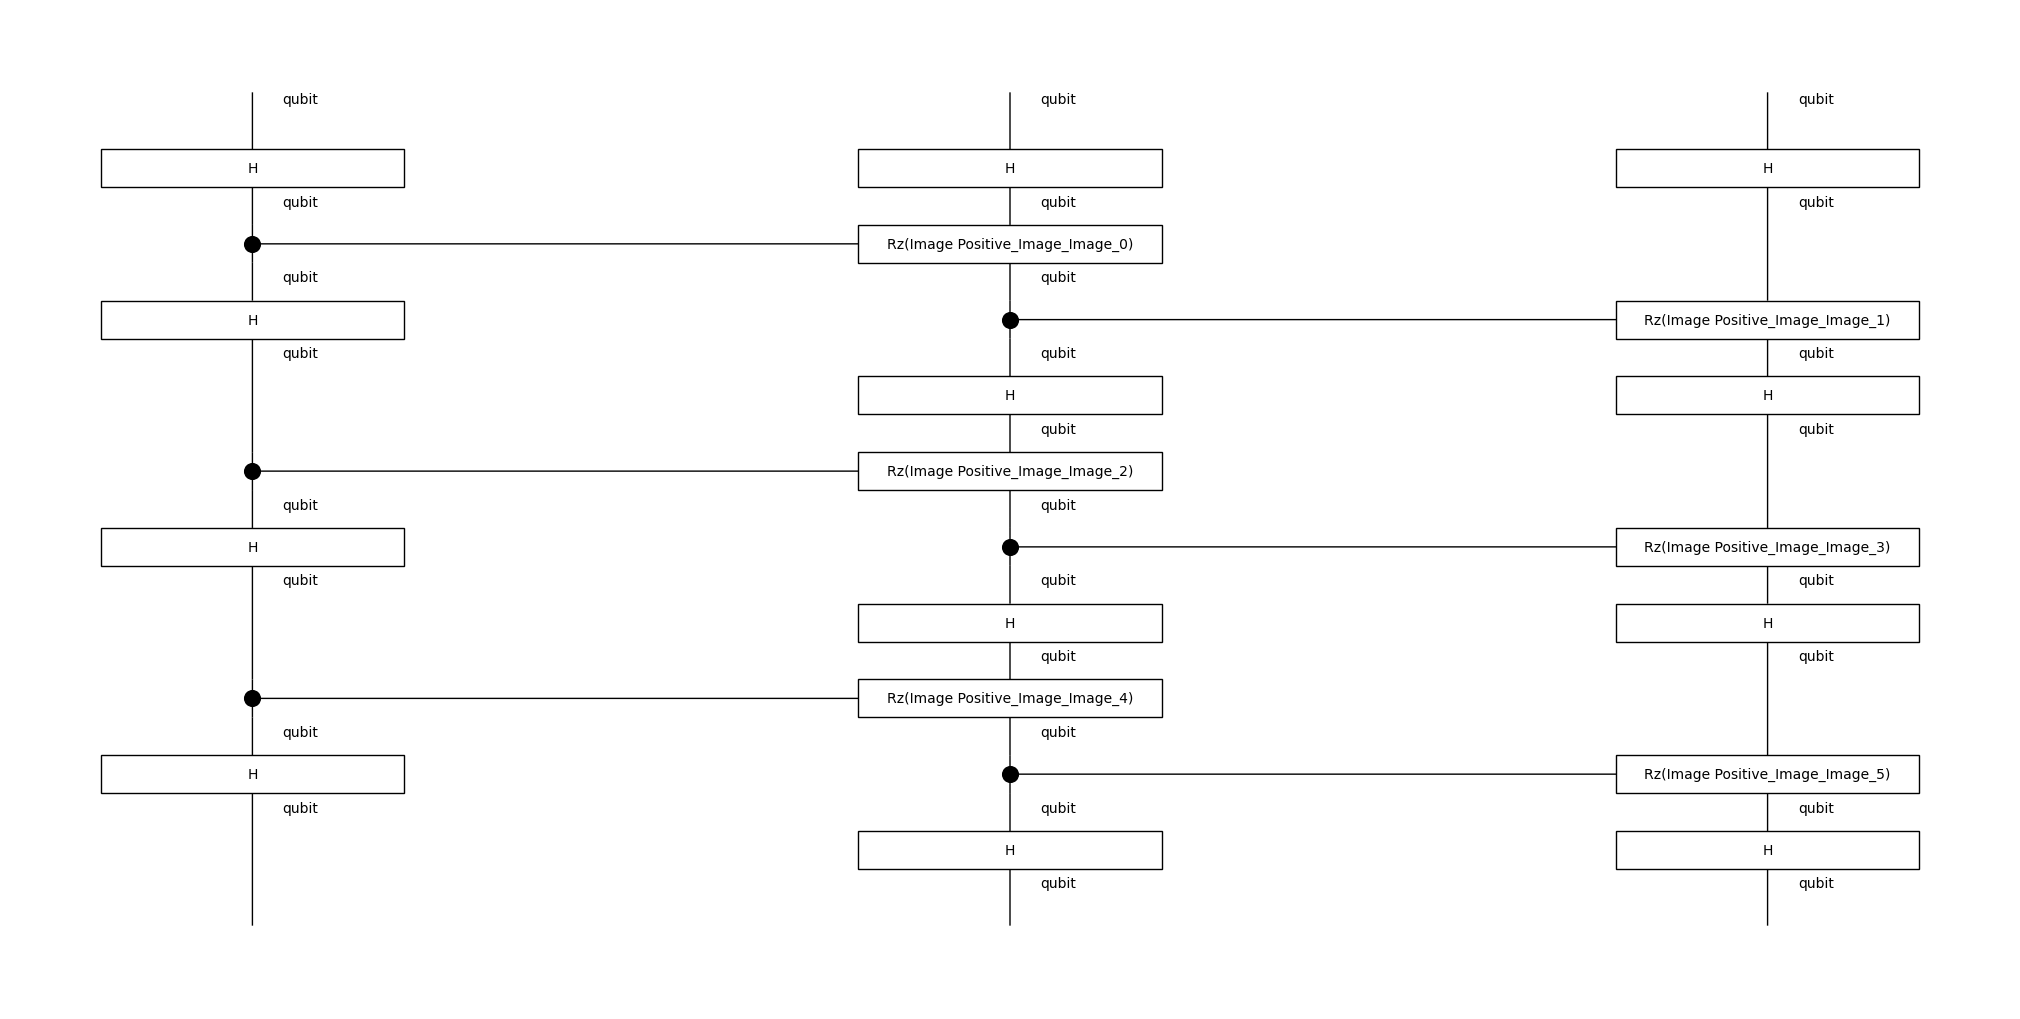

In [14]:
# 3 Qubits
ob_map = {Image: 3}
n_layers = 3

ansatz = IQPAnsatz(ob_map=ob_map, n_layers=n_layers)

quantum_circuit = ansatz(image_diagram)

# Print or visualize the quantum circuit
print(quantum_circuit)
quantum_circuit.draw(output='mpl', figsize=(20, 10))